In [45]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
#if i want to speed up and use one file
#files2 = "CSVLog_20190518_122417.csv"

#i aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set
files = "aggregate_no_time_column.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

In [47]:
dataset.tail()

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG),Total fuel economy (MPG)
6633,18.03922,11.76471,59.0,29.8254,29.01961,885.903,183.2,658.75,67.05882,424.9606,0.994239,5.0,71.6,11.51674,-0.78125,0.308259,0.0,0.205909,0.0,30.11613
6634,17.64706,11.76471,59.0,29.8254,29.01961,885.903,183.2,640.00,67.05882,449.6170,0.994239,4.5,71.6,11.51674,-0.78125,0.257985,0.0,0.172327,0.0,30.11534
6635,17.64706,11.37255,59.0,29.8254,29.41176,885.903,183.2,607.75,67.05882,429.3117,0.994239,4.0,71.6,11.51674,-0.78125,0.325458,0.0,0.217398,0.0,30.11455
6636,17.25490,11.37255,59.0,29.8254,29.41176,885.903,183.2,606.75,67.05882,449.6170,0.994239,6.5,71.6,11.51674,-0.78125,0.239463,0.0,0.159955,0.0,30.11384
6637,17.64706,11.37255,59.0,29.8254,29.80392,885.903,183.2,604.50,67.05882,429.3117,0.994239,6.0,71.6,11.51674,-0.78125,0.227556,0.0,0.152002,0.0,30.11316


In [48]:
%%time 
#set seed here!

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(dataset)

train_labels = train.pop("Total fuel economy (MPG)")
validate_labels = validate.pop("Total fuel economy (MPG)")
test_labels = test.pop("Total fuel economy (MPG)")
dataset.tail()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.76 ms


In [ ]:
#test_labels
#train.dtypes

In [49]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
train_stats = train.describe(include = 'all')
#train_stats = train.transpose()
train_stats
# training stats is a pandas data frame type
# use these values to normalize


,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,34.506652,21.082814,67.781969,29.721949,42.411538,1830.253671,185.514164,1495.913737,74.706474,913.395009,0.980684,21.032145,73.586439,17.624916,5.333179,1.470546,30.841358,0.994327,59.839823
std,23.955009,13.547634,12.659770,0.692713,25.839407,1150.997878,8.303590,642.948353,10.805701,559.094388,0.035883,15.240638,14.081990,8.757362,3.918283,1.557026,22.669125,1.048707,77.174420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,-2.343750,0.000000,0.000000,0.000000,0.000000
25%,16.078430,12.156860,62.600000,29.530100,20.882350,885.903000,183.200000,1040.500000,67.450980,474.273400,0.990305,4.500000,64.400000,10.335540,2.343750,0.309582,10.097282,0.209839,10.875613
50%,24.705880,15.294120,62.600000,29.825400,38.431370,1213.687000,185.000000,1454.750000,74.509800,617.860800,0.993233,23.750000,68.000000,15.060350,5.468750,0.789170,30.447190,0.536663,31.900475
75%,48.627450,26.666670,66.200000,29.825400,56.078430,2554.354000,188.600000,1973.437500,81.176470,1257.477000,0.995459,35.000000,77.000000,26.872390,7.812500,2.185596,45.360100,1.475110,82.868613
max,99.215680,90.980390,118.400000,30.120700,100.000000,5906.020000,204.800000,4719.500000,93.333340,2981.976000,1.016260,47.500000,122.000000,30.711300,12.500000,11.959920,76.428660,8.026347,1252.727000


In [77]:
# Even if we make our own, the values are similar but not exact. mine vs their mean and var
# issue: i am copying the set, find better way to not copy huge set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean
def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var
# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    print("entered norm function")
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)
        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

entered norm function
entered norm function
entered norm function


In [ ]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# These things are buggy, change
# scaler = StandardScaler()
# normed_train = scaler.fit_transform(train)
# normed_validate = scaler.fit_transform(validate)
# normed_test = scaler.fit_transform(test)

# Fixes to make: normalize each data set by finding mean and STD of the training set
# and use these numbers to normalize all three sets
# TODO: Create mean and STD

#not technically correct
#from tf regression website
#Note: Although we intentionally generate these statistics from only the training dataset, 
#these statistics will also be used to normalize the test dataset. We need to do that to project the test 
#dataset into the same distribution that the model has been trained on.

#I normalize it according to the mean and sd of each predictor from each set instead of normalizaing from 
#training set only

In [9]:
#debugging
#normed_train

In [78]:
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_B():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


In [79]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 421
Trainable params: 421
Non-trainable params: 0
__________________________

In [80]:
%%time
# Also buggy: 

#change batch size?
#try early stop?
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=1000, verbose=2,
         validation_data=(normed_validate, validate_labels))


Train on 3982 samples, validate on 1327 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 0s - loss: 810.7255 - mean_absolute_error: 28.2676 - mean_squared_error: 810.7253 - val_loss: 756.7125 - val_mean_absolute_error: 27.3038 - val_mean_squared_error: 756.7125
Epoch 2/1000
 - 0s - loss: 709.3466 - mean_absolute_error: 26.4186 - mean_squared_error: 709.3466 - val_loss: 650.8718 - val_mean_absolute_error: 25.2651 - val_mean_squared_error: 650.8718
Epoch 3/1000
 - 0s - loss: 602.5353 - mean_absolute_error: 24.2568 - mean_squared_error: 602.5354 - val_loss: 541.8944 - val_mean_absolute_error: 22.9160 - val_mean_squared_error: 541.8945
Epoch 4/1000
 - 0s - loss: 493.1881 - mean_absolute_error: 21.7538 - mean_squared_error: 493.1882 - val_loss: 432.2711 - val_mean_absolute_error: 20.2032 - val_mean_squared_error: 432.2711
Epoch 5/1000
 - 0s - loss: 386.1234 - mean_absolute_error: 18.8911 - mean_squared_error: 386.1233 - val_loss: 328.1194 - val_mean_absolute_error: 17

Epoch 44/1000
 - 0s - loss: 7.2929 - mean_absolute_error: 1.9732 - mean_squared_error: 7.2929 - val_loss: 6.9091 - val_mean_absolute_error: 1.9008 - val_mean_squared_error: 6.9091
Epoch 45/1000
 - 0s - loss: 7.0909 - mean_absolute_error: 1.9459 - mean_squared_error: 7.0909 - val_loss: 6.7227 - val_mean_absolute_error: 1.8838 - val_mean_squared_error: 6.7227
Epoch 46/1000
 - 0s - loss: 6.8931 - mean_absolute_error: 1.9237 - mean_squared_error: 6.8931 - val_loss: 6.4995 - val_mean_absolute_error: 1.8483 - val_mean_squared_error: 6.4995
Epoch 47/1000
 - 0s - loss: 6.6879 - mean_absolute_error: 1.8973 - mean_squared_error: 6.6879 - val_loss: 6.3595 - val_mean_absolute_error: 1.8198 - val_mean_squared_error: 6.3595
Epoch 48/1000
 - 0s - loss: 6.5137 - mean_absolute_error: 1.8672 - mean_squared_error: 6.5137 - val_loss: 6.1745 - val_mean_absolute_error: 1.8007 - val_mean_squared_error: 6.1745
Epoch 49/1000
 - 0s - loss: 6.3340 - mean_absolute_error: 1.8488 - mean_squared_error: 6.3340 - val_

Epoch 90/1000
 - 0s - loss: 3.0362 - mean_absolute_error: 1.1991 - mean_squared_error: 3.0362 - val_loss: 3.2603 - val_mean_absolute_error: 1.2381 - val_mean_squared_error: 3.2603
Epoch 91/1000
 - 0s - loss: 2.9985 - mean_absolute_error: 1.1839 - mean_squared_error: 2.9985 - val_loss: 3.2134 - val_mean_absolute_error: 1.2232 - val_mean_squared_error: 3.2134
Epoch 92/1000
 - 0s - loss: 2.9801 - mean_absolute_error: 1.1786 - mean_squared_error: 2.9801 - val_loss: 3.2055 - val_mean_absolute_error: 1.2428 - val_mean_squared_error: 3.2055
Epoch 93/1000
 - 0s - loss: 2.9470 - mean_absolute_error: 1.1681 - mean_squared_error: 2.9470 - val_loss: 3.1381 - val_mean_absolute_error: 1.2198 - val_mean_squared_error: 3.1381
Epoch 94/1000
 - 0s - loss: 2.9216 - mean_absolute_error: 1.1611 - mean_squared_error: 2.9216 - val_loss: 3.1750 - val_mean_absolute_error: 1.2131 - val_mean_squared_error: 3.1750
Epoch 95/1000
 - 0s - loss: 2.8988 - mean_absolute_error: 1.1501 - mean_squared_error: 2.8988 - val_

Epoch 136/1000
 - 0s - loss: 2.4317 - mean_absolute_error: 1.0259 - mean_squared_error: 2.4317 - val_loss: 2.5664 - val_mean_absolute_error: 1.0554 - val_mean_squared_error: 2.5664
Epoch 137/1000
 - 0s - loss: 2.4502 - mean_absolute_error: 1.0226 - mean_squared_error: 2.4502 - val_loss: 2.5865 - val_mean_absolute_error: 1.0588 - val_mean_squared_error: 2.5865
Epoch 138/1000
 - 0s - loss: 2.4137 - mean_absolute_error: 1.0174 - mean_squared_error: 2.4137 - val_loss: 2.6223 - val_mean_absolute_error: 1.0818 - val_mean_squared_error: 2.6223
Epoch 139/1000
 - 0s - loss: 2.4151 - mean_absolute_error: 1.0138 - mean_squared_error: 2.4151 - val_loss: 2.5391 - val_mean_absolute_error: 1.0588 - val_mean_squared_error: 2.5391
Epoch 140/1000
 - 0s - loss: 2.3852 - mean_absolute_error: 1.0143 - mean_squared_error: 2.3852 - val_loss: 2.5972 - val_mean_absolute_error: 1.0747 - val_mean_squared_error: 2.5972
Epoch 141/1000
 - 0s - loss: 2.3729 - mean_absolute_error: 1.0114 - mean_squared_error: 2.3729 

Epoch 182/1000
 - 0s - loss: 2.0664 - mean_absolute_error: 0.9206 - mean_squared_error: 2.0664 - val_loss: 2.1728 - val_mean_absolute_error: 0.9474 - val_mean_squared_error: 2.1728
Epoch 183/1000
 - 0s - loss: 2.0398 - mean_absolute_error: 0.9167 - mean_squared_error: 2.0398 - val_loss: 2.1752 - val_mean_absolute_error: 0.9413 - val_mean_squared_error: 2.1752
Epoch 184/1000
 - 0s - loss: 2.0320 - mean_absolute_error: 0.9140 - mean_squared_error: 2.0320 - val_loss: 2.1670 - val_mean_absolute_error: 0.9482 - val_mean_squared_error: 2.1670
Epoch 185/1000
 - 0s - loss: 2.0316 - mean_absolute_error: 0.9151 - mean_squared_error: 2.0316 - val_loss: 2.1386 - val_mean_absolute_error: 0.9489 - val_mean_squared_error: 2.1386
Epoch 186/1000
 - 0s - loss: 2.0303 - mean_absolute_error: 0.9136 - mean_squared_error: 2.0303 - val_loss: 2.1650 - val_mean_absolute_error: 0.9469 - val_mean_squared_error: 2.1650
Epoch 187/1000
 - 0s - loss: 2.0233 - mean_absolute_error: 0.9084 - mean_squared_error: 2.0233 

Epoch 228/1000
 - 0s - loss: 1.7765 - mean_absolute_error: 0.8510 - mean_squared_error: 1.7765 - val_loss: 1.9647 - val_mean_absolute_error: 0.8949 - val_mean_squared_error: 1.9647
Epoch 229/1000
 - 0s - loss: 1.7798 - mean_absolute_error: 0.8494 - mean_squared_error: 1.7798 - val_loss: 1.9708 - val_mean_absolute_error: 0.8982 - val_mean_squared_error: 1.9708
Epoch 230/1000
 - 0s - loss: 1.7809 - mean_absolute_error: 0.8495 - mean_squared_error: 1.7809 - val_loss: 1.9894 - val_mean_absolute_error: 0.8998 - val_mean_squared_error: 1.9894
Epoch 231/1000
 - 0s - loss: 1.7760 - mean_absolute_error: 0.8467 - mean_squared_error: 1.7760 - val_loss: 1.9615 - val_mean_absolute_error: 0.8982 - val_mean_squared_error: 1.9615
Epoch 232/1000
 - 0s - loss: 1.7577 - mean_absolute_error: 0.8476 - mean_squared_error: 1.7577 - val_loss: 1.9508 - val_mean_absolute_error: 0.8901 - val_mean_squared_error: 1.9508
Epoch 233/1000
 - 0s - loss: 1.7468 - mean_absolute_error: 0.8459 - mean_squared_error: 1.7468 

Epoch 274/1000
 - 0s - loss: 1.6168 - mean_absolute_error: 0.8109 - mean_squared_error: 1.6168 - val_loss: 1.8864 - val_mean_absolute_error: 0.8830 - val_mean_squared_error: 1.8864
Epoch 275/1000
 - 0s - loss: 1.6069 - mean_absolute_error: 0.8101 - mean_squared_error: 1.6069 - val_loss: 1.7986 - val_mean_absolute_error: 0.8507 - val_mean_squared_error: 1.7986
Epoch 276/1000
 - 0s - loss: 1.5926 - mean_absolute_error: 0.8096 - mean_squared_error: 1.5926 - val_loss: 1.7607 - val_mean_absolute_error: 0.8396 - val_mean_squared_error: 1.7607
Epoch 277/1000
 - 0s - loss: 1.5928 - mean_absolute_error: 0.8058 - mean_squared_error: 1.5928 - val_loss: 1.7763 - val_mean_absolute_error: 0.8401 - val_mean_squared_error: 1.7763
Epoch 278/1000
 - 0s - loss: 1.5979 - mean_absolute_error: 0.8045 - mean_squared_error: 1.5979 - val_loss: 1.7790 - val_mean_absolute_error: 0.8506 - val_mean_squared_error: 1.7790
Epoch 279/1000
 - 0s - loss: 1.5929 - mean_absolute_error: 0.8047 - mean_squared_error: 1.5929 

Epoch 320/1000
 - 0s - loss: 1.2317 - mean_absolute_error: 0.7693 - mean_squared_error: 1.2317 - val_loss: 1.3388 - val_mean_absolute_error: 0.8293 - val_mean_squared_error: 1.3388
Epoch 321/1000
 - 0s - loss: 1.2336 - mean_absolute_error: 0.7670 - mean_squared_error: 1.2336 - val_loss: 1.3287 - val_mean_absolute_error: 0.8250 - val_mean_squared_error: 1.3287
Epoch 322/1000
 - 0s - loss: 1.2359 - mean_absolute_error: 0.7678 - mean_squared_error: 1.2359 - val_loss: 1.3046 - val_mean_absolute_error: 0.8104 - val_mean_squared_error: 1.3046
Epoch 323/1000
 - 0s - loss: 1.2292 - mean_absolute_error: 0.7696 - mean_squared_error: 1.2292 - val_loss: 1.2744 - val_mean_absolute_error: 0.8028 - val_mean_squared_error: 1.2744
Epoch 324/1000
 - 0s - loss: 1.2238 - mean_absolute_error: 0.7681 - mean_squared_error: 1.2238 - val_loss: 1.3083 - val_mean_absolute_error: 0.8180 - val_mean_squared_error: 1.3083
Epoch 325/1000
 - 0s - loss: 1.2287 - mean_absolute_error: 0.7694 - mean_squared_error: 1.2287 

Epoch 366/1000
 - 0s - loss: 1.1969 - mean_absolute_error: 0.7556 - mean_squared_error: 1.1969 - val_loss: 1.3630 - val_mean_absolute_error: 0.8320 - val_mean_squared_error: 1.3630
Epoch 367/1000
 - 0s - loss: 1.1983 - mean_absolute_error: 0.7578 - mean_squared_error: 1.1983 - val_loss: 1.3132 - val_mean_absolute_error: 0.8069 - val_mean_squared_error: 1.3132
Epoch 368/1000
 - 0s - loss: 1.1798 - mean_absolute_error: 0.7537 - mean_squared_error: 1.1798 - val_loss: 1.3986 - val_mean_absolute_error: 0.8441 - val_mean_squared_error: 1.3986
Epoch 369/1000
 - 0s - loss: 1.2016 - mean_absolute_error: 0.7552 - mean_squared_error: 1.2016 - val_loss: 1.3427 - val_mean_absolute_error: 0.8212 - val_mean_squared_error: 1.3427
Epoch 370/1000
 - 0s - loss: 1.1963 - mean_absolute_error: 0.7538 - mean_squared_error: 1.1963 - val_loss: 1.3735 - val_mean_absolute_error: 0.8338 - val_mean_squared_error: 1.3735
Epoch 371/1000
 - 0s - loss: 1.1798 - mean_absolute_error: 0.7553 - mean_squared_error: 1.1798 

Epoch 412/1000
 - 0s - loss: 1.1592 - mean_absolute_error: 0.7500 - mean_squared_error: 1.1592 - val_loss: 1.2577 - val_mean_absolute_error: 0.7955 - val_mean_squared_error: 1.2577
Epoch 413/1000
 - 0s - loss: 1.1651 - mean_absolute_error: 0.7492 - mean_squared_error: 1.1651 - val_loss: 1.2890 - val_mean_absolute_error: 0.8059 - val_mean_squared_error: 1.2890
Epoch 414/1000
 - 0s - loss: 1.1554 - mean_absolute_error: 0.7486 - mean_squared_error: 1.1554 - val_loss: 1.2493 - val_mean_absolute_error: 0.8016 - val_mean_squared_error: 1.2493
Epoch 415/1000
 - 0s - loss: 1.1547 - mean_absolute_error: 0.7468 - mean_squared_error: 1.1547 - val_loss: 1.2547 - val_mean_absolute_error: 0.8062 - val_mean_squared_error: 1.2547
Epoch 416/1000
 - 0s - loss: 1.1593 - mean_absolute_error: 0.7437 - mean_squared_error: 1.1593 - val_loss: 1.2882 - val_mean_absolute_error: 0.8028 - val_mean_squared_error: 1.2882
Epoch 417/1000
 - 0s - loss: 1.1494 - mean_absolute_error: 0.7453 - mean_squared_error: 1.1494 

Epoch 458/1000
 - 0s - loss: 1.1379 - mean_absolute_error: 0.7381 - mean_squared_error: 1.1379 - val_loss: 1.2725 - val_mean_absolute_error: 0.7966 - val_mean_squared_error: 1.2725
Epoch 459/1000
 - 0s - loss: 1.1248 - mean_absolute_error: 0.7397 - mean_squared_error: 1.1248 - val_loss: 1.2576 - val_mean_absolute_error: 0.7943 - val_mean_squared_error: 1.2576
Epoch 460/1000
 - 0s - loss: 1.1502 - mean_absolute_error: 0.7449 - mean_squared_error: 1.1502 - val_loss: 1.2643 - val_mean_absolute_error: 0.7908 - val_mean_squared_error: 1.2643
Epoch 461/1000
 - 0s - loss: 1.1505 - mean_absolute_error: 0.7431 - mean_squared_error: 1.1505 - val_loss: 1.2297 - val_mean_absolute_error: 0.7872 - val_mean_squared_error: 1.2297
Epoch 462/1000
 - 0s - loss: 1.1326 - mean_absolute_error: 0.7433 - mean_squared_error: 1.1326 - val_loss: 1.2536 - val_mean_absolute_error: 0.7849 - val_mean_squared_error: 1.2536
Epoch 463/1000
 - 0s - loss: 1.1117 - mean_absolute_error: 0.7443 - mean_squared_error: 1.1117 

Epoch 504/1000
 - 0s - loss: 1.1109 - mean_absolute_error: 0.7390 - mean_squared_error: 1.1109 - val_loss: 1.2752 - val_mean_absolute_error: 0.7835 - val_mean_squared_error: 1.2752
Epoch 505/1000
 - 0s - loss: 1.1197 - mean_absolute_error: 0.7359 - mean_squared_error: 1.1197 - val_loss: 1.2881 - val_mean_absolute_error: 0.7939 - val_mean_squared_error: 1.2881
Epoch 506/1000
 - 0s - loss: 1.1111 - mean_absolute_error: 0.7358 - mean_squared_error: 1.1111 - val_loss: 1.2856 - val_mean_absolute_error: 0.7911 - val_mean_squared_error: 1.2856
Epoch 507/1000
 - 0s - loss: 1.1096 - mean_absolute_error: 0.7383 - mean_squared_error: 1.1096 - val_loss: 1.2406 - val_mean_absolute_error: 0.7889 - val_mean_squared_error: 1.2406
Epoch 508/1000
 - 0s - loss: 1.1109 - mean_absolute_error: 0.7408 - mean_squared_error: 1.1109 - val_loss: 1.2273 - val_mean_absolute_error: 0.7767 - val_mean_squared_error: 1.2273
Epoch 509/1000
 - 0s - loss: 1.1230 - mean_absolute_error: 0.7371 - mean_squared_error: 1.1230 

Epoch 550/1000
 - 0s - loss: 1.1199 - mean_absolute_error: 0.7329 - mean_squared_error: 1.1199 - val_loss: 1.2857 - val_mean_absolute_error: 0.7883 - val_mean_squared_error: 1.2857
Epoch 551/1000
 - 0s - loss: 1.1087 - mean_absolute_error: 0.7374 - mean_squared_error: 1.1087 - val_loss: 1.2441 - val_mean_absolute_error: 0.7773 - val_mean_squared_error: 1.2441
Epoch 552/1000
 - 0s - loss: 1.1029 - mean_absolute_error: 0.7336 - mean_squared_error: 1.1029 - val_loss: 1.2568 - val_mean_absolute_error: 0.7915 - val_mean_squared_error: 1.2568
Epoch 553/1000
 - 0s - loss: 1.1130 - mean_absolute_error: 0.7337 - mean_squared_error: 1.1130 - val_loss: 1.3003 - val_mean_absolute_error: 0.8047 - val_mean_squared_error: 1.3003
Epoch 554/1000
 - 0s - loss: 1.1053 - mean_absolute_error: 0.7354 - mean_squared_error: 1.1053 - val_loss: 1.4246 - val_mean_absolute_error: 0.8439 - val_mean_squared_error: 1.4246
Epoch 555/1000
 - 0s - loss: 1.1000 - mean_absolute_error: 0.7331 - mean_squared_error: 1.1000 

Epoch 596/1000
 - 0s - loss: 1.0952 - mean_absolute_error: 0.7315 - mean_squared_error: 1.0952 - val_loss: 1.3156 - val_mean_absolute_error: 0.7939 - val_mean_squared_error: 1.3156
Epoch 597/1000
 - 0s - loss: 1.1203 - mean_absolute_error: 0.7300 - mean_squared_error: 1.1203 - val_loss: 1.2612 - val_mean_absolute_error: 0.7861 - val_mean_squared_error: 1.2612
Epoch 598/1000
 - 0s - loss: 1.1014 - mean_absolute_error: 0.7310 - mean_squared_error: 1.1014 - val_loss: 1.2966 - val_mean_absolute_error: 0.7878 - val_mean_squared_error: 1.2966
Epoch 599/1000
 - 0s - loss: 1.0943 - mean_absolute_error: 0.7313 - mean_squared_error: 1.0943 - val_loss: 1.2691 - val_mean_absolute_error: 0.7960 - val_mean_squared_error: 1.2691
Epoch 600/1000
 - 0s - loss: 1.0853 - mean_absolute_error: 0.7326 - mean_squared_error: 1.0853 - val_loss: 1.3767 - val_mean_absolute_error: 0.8189 - val_mean_squared_error: 1.3767
Epoch 601/1000
 - 0s - loss: 1.0852 - mean_absolute_error: 0.7333 - mean_squared_error: 1.0852 

Epoch 642/1000
 - 0s - loss: 1.0927 - mean_absolute_error: 0.7294 - mean_squared_error: 1.0927 - val_loss: 1.2695 - val_mean_absolute_error: 0.7883 - val_mean_squared_error: 1.2695
Epoch 643/1000
 - 0s - loss: 1.0945 - mean_absolute_error: 0.7296 - mean_squared_error: 1.0945 - val_loss: 1.4089 - val_mean_absolute_error: 0.8338 - val_mean_squared_error: 1.4089
Epoch 644/1000
 - 0s - loss: 1.0800 - mean_absolute_error: 0.7306 - mean_squared_error: 1.0800 - val_loss: 1.2934 - val_mean_absolute_error: 0.7845 - val_mean_squared_error: 1.2934
Epoch 645/1000
 - 0s - loss: 1.0803 - mean_absolute_error: 0.7283 - mean_squared_error: 1.0803 - val_loss: 1.3154 - val_mean_absolute_error: 0.7981 - val_mean_squared_error: 1.3154
Epoch 646/1000
 - 0s - loss: 1.0905 - mean_absolute_error: 0.7290 - mean_squared_error: 1.0905 - val_loss: 1.3013 - val_mean_absolute_error: 0.7915 - val_mean_squared_error: 1.3013
Epoch 647/1000
 - 0s - loss: 1.0787 - mean_absolute_error: 0.7295 - mean_squared_error: 1.0787 

Epoch 688/1000
 - 0s - loss: 1.0744 - mean_absolute_error: 0.7270 - mean_squared_error: 1.0744 - val_loss: 1.2850 - val_mean_absolute_error: 0.7874 - val_mean_squared_error: 1.2850
Epoch 689/1000
 - 0s - loss: 1.0548 - mean_absolute_error: 0.7272 - mean_squared_error: 1.0548 - val_loss: 1.4907 - val_mean_absolute_error: 0.8720 - val_mean_squared_error: 1.4907
Epoch 690/1000
 - 0s - loss: 1.0731 - mean_absolute_error: 0.7280 - mean_squared_error: 1.0731 - val_loss: 1.2594 - val_mean_absolute_error: 0.7846 - val_mean_squared_error: 1.2594
Epoch 691/1000
 - 0s - loss: 1.0703 - mean_absolute_error: 0.7266 - mean_squared_error: 1.0703 - val_loss: 1.2606 - val_mean_absolute_error: 0.7937 - val_mean_squared_error: 1.2606
Epoch 692/1000
 - 0s - loss: 1.0790 - mean_absolute_error: 0.7265 - mean_squared_error: 1.0790 - val_loss: 1.3411 - val_mean_absolute_error: 0.8021 - val_mean_squared_error: 1.3411
Epoch 693/1000
 - 0s - loss: 1.0747 - mean_absolute_error: 0.7294 - mean_squared_error: 1.0747 

Epoch 734/1000
 - 0s - loss: 1.0343 - mean_absolute_error: 0.7218 - mean_squared_error: 1.0343 - val_loss: 1.2391 - val_mean_absolute_error: 0.7753 - val_mean_squared_error: 1.2391
Epoch 735/1000
 - 0s - loss: 1.0583 - mean_absolute_error: 0.7244 - mean_squared_error: 1.0583 - val_loss: 1.3101 - val_mean_absolute_error: 0.7907 - val_mean_squared_error: 1.3101
Epoch 736/1000
 - 0s - loss: 1.0547 - mean_absolute_error: 0.7243 - mean_squared_error: 1.0547 - val_loss: 1.2657 - val_mean_absolute_error: 0.7823 - val_mean_squared_error: 1.2657
Epoch 737/1000
 - 0s - loss: 1.0471 - mean_absolute_error: 0.7259 - mean_squared_error: 1.0471 - val_loss: 1.3382 - val_mean_absolute_error: 0.8032 - val_mean_squared_error: 1.3382
Epoch 738/1000
 - 0s - loss: 1.0535 - mean_absolute_error: 0.7230 - mean_squared_error: 1.0535 - val_loss: 1.2716 - val_mean_absolute_error: 0.7934 - val_mean_squared_error: 1.2716
Epoch 739/1000
 - 0s - loss: 1.0735 - mean_absolute_error: 0.7256 - mean_squared_error: 1.0735 

Epoch 780/1000
 - 0s - loss: 1.0373 - mean_absolute_error: 0.7244 - mean_squared_error: 1.0373 - val_loss: 1.3063 - val_mean_absolute_error: 0.7938 - val_mean_squared_error: 1.3063
Epoch 781/1000
 - 0s - loss: 1.0288 - mean_absolute_error: 0.7241 - mean_squared_error: 1.0288 - val_loss: 1.2840 - val_mean_absolute_error: 0.7908 - val_mean_squared_error: 1.2840
Epoch 782/1000
 - 0s - loss: 1.0527 - mean_absolute_error: 0.7250 - mean_squared_error: 1.0527 - val_loss: 1.3476 - val_mean_absolute_error: 0.8131 - val_mean_squared_error: 1.3476
Epoch 783/1000
 - 0s - loss: 1.0582 - mean_absolute_error: 0.7258 - mean_squared_error: 1.0582 - val_loss: 1.2232 - val_mean_absolute_error: 0.7709 - val_mean_squared_error: 1.2232
Epoch 784/1000
 - 0s - loss: 1.0397 - mean_absolute_error: 0.7191 - mean_squared_error: 1.0397 - val_loss: 1.2788 - val_mean_absolute_error: 0.7910 - val_mean_squared_error: 1.2788
Epoch 785/1000
 - 0s - loss: 1.0303 - mean_absolute_error: 0.7247 - mean_squared_error: 1.0303 

Epoch 826/1000
 - 0s - loss: 1.0433 - mean_absolute_error: 0.7190 - mean_squared_error: 1.0433 - val_loss: 1.3131 - val_mean_absolute_error: 0.8000 - val_mean_squared_error: 1.3131
Epoch 827/1000
 - 0s - loss: 1.0421 - mean_absolute_error: 0.7185 - mean_squared_error: 1.0421 - val_loss: 1.2725 - val_mean_absolute_error: 0.7858 - val_mean_squared_error: 1.2725
Epoch 828/1000
 - 0s - loss: 1.0315 - mean_absolute_error: 0.7190 - mean_squared_error: 1.0315 - val_loss: 1.2921 - val_mean_absolute_error: 0.7931 - val_mean_squared_error: 1.2921
Epoch 829/1000
 - 0s - loss: 1.0405 - mean_absolute_error: 0.7197 - mean_squared_error: 1.0405 - val_loss: 1.3300 - val_mean_absolute_error: 0.8034 - val_mean_squared_error: 1.3300
Epoch 830/1000
 - 0s - loss: 1.0569 - mean_absolute_error: 0.7186 - mean_squared_error: 1.0569 - val_loss: 1.3062 - val_mean_absolute_error: 0.7969 - val_mean_squared_error: 1.3062
Epoch 831/1000
 - 0s - loss: 1.0391 - mean_absolute_error: 0.7207 - mean_squared_error: 1.0391 

Epoch 872/1000
 - 0s - loss: 1.0256 - mean_absolute_error: 0.7211 - mean_squared_error: 1.0256 - val_loss: 1.3032 - val_mean_absolute_error: 0.7891 - val_mean_squared_error: 1.3032
Epoch 873/1000
 - 0s - loss: 1.0110 - mean_absolute_error: 0.7198 - mean_squared_error: 1.0110 - val_loss: 1.2448 - val_mean_absolute_error: 0.7827 - val_mean_squared_error: 1.2448
Epoch 874/1000
 - 0s - loss: 1.0331 - mean_absolute_error: 0.7199 - mean_squared_error: 1.0331 - val_loss: 1.2982 - val_mean_absolute_error: 0.7937 - val_mean_squared_error: 1.2982
Epoch 875/1000
 - 0s - loss: 1.0350 - mean_absolute_error: 0.7191 - mean_squared_error: 1.0350 - val_loss: 1.3022 - val_mean_absolute_error: 0.7949 - val_mean_squared_error: 1.3022
Epoch 876/1000
 - 0s - loss: 1.0233 - mean_absolute_error: 0.7189 - mean_squared_error: 1.0233 - val_loss: 1.2852 - val_mean_absolute_error: 0.7907 - val_mean_squared_error: 1.2852
Epoch 877/1000
 - 0s - loss: 1.0161 - mean_absolute_error: 0.7202 - mean_squared_error: 1.0161 

Epoch 918/1000
 - 0s - loss: 1.0211 - mean_absolute_error: 0.7146 - mean_squared_error: 1.0211 - val_loss: 1.2636 - val_mean_absolute_error: 0.7948 - val_mean_squared_error: 1.2636
Epoch 919/1000
 - 0s - loss: 1.0312 - mean_absolute_error: 0.7142 - mean_squared_error: 1.0312 - val_loss: 1.2937 - val_mean_absolute_error: 0.7905 - val_mean_squared_error: 1.2937
Epoch 920/1000
 - 0s - loss: 1.0259 - mean_absolute_error: 0.7193 - mean_squared_error: 1.0259 - val_loss: 1.2910 - val_mean_absolute_error: 0.7860 - val_mean_squared_error: 1.2910
Epoch 921/1000
 - 0s - loss: 1.0310 - mean_absolute_error: 0.7198 - mean_squared_error: 1.0310 - val_loss: 1.3254 - val_mean_absolute_error: 0.8010 - val_mean_squared_error: 1.3254
Epoch 922/1000
 - 0s - loss: 1.0255 - mean_absolute_error: 0.7164 - mean_squared_error: 1.0255 - val_loss: 1.2856 - val_mean_absolute_error: 0.7937 - val_mean_squared_error: 1.2856
Epoch 923/1000
 - 0s - loss: 1.0171 - mean_absolute_error: 0.7174 - mean_squared_error: 1.0171 

Epoch 964/1000
 - 0s - loss: 1.0234 - mean_absolute_error: 0.7121 - mean_squared_error: 1.0234 - val_loss: 1.2482 - val_mean_absolute_error: 0.7841 - val_mean_squared_error: 1.2482
Epoch 965/1000
 - 0s - loss: 1.0111 - mean_absolute_error: 0.7122 - mean_squared_error: 1.0111 - val_loss: 1.3290 - val_mean_absolute_error: 0.7935 - val_mean_squared_error: 1.3290
Epoch 966/1000
 - 0s - loss: 1.0290 - mean_absolute_error: 0.7152 - mean_squared_error: 1.0290 - val_loss: 1.2897 - val_mean_absolute_error: 0.8012 - val_mean_squared_error: 1.2897
Epoch 967/1000
 - 0s - loss: 1.0187 - mean_absolute_error: 0.7142 - mean_squared_error: 1.0187 - val_loss: 1.4940 - val_mean_absolute_error: 0.8605 - val_mean_squared_error: 1.4940
Epoch 968/1000
 - 0s - loss: 1.0123 - mean_absolute_error: 0.7155 - mean_squared_error: 1.0123 - val_loss: 1.3269 - val_mean_absolute_error: 0.7910 - val_mean_squared_error: 1.3269
Epoch 969/1000
 - 0s - loss: 1.0049 - mean_absolute_error: 0.7145 - mean_squared_error: 1.0049 

In [81]:
%%time
history_object_B = model_B.fit(normed_train, train_labels, epochs=1000, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 3982 samples, validate on 1327 samples
Epoch 1/1000
 - 0s - loss: 777.4943 - mean_absolute_error: 27.6588 - mean_squared_error: 777.4942 - val_loss: 691.3531 - val_mean_absolute_error: 26.0404 - val_mean_squared_error: 691.3532
Epoch 2/1000
 - 0s - loss: 606.6508 - mean_absolute_error: 24.2782 - mean_squared_error: 606.6508 - val_loss: 504.2155 - val_mean_absolute_error: 21.9852 - val_mean_squared_error: 504.2154
Epoch 3/1000
 - 0s - loss: 408.4189 - mean_absolute_error: 19.4627 - mean_squared_error: 408.4188 - val_loss: 299.9700 - val_mean_absolute_error: 16.2734 - val_mean_squared_error: 299.9700
Epoch 4/1000
 - 0s - loss: 225.0746 - mean_absolute_error: 13.6479 - mean_squared_error: 225.0745 - val_loss: 147.7330 - val_mean_absolute_error: 10.4657 - val_mean_squared_error: 147.7331
Epoch 5/1000
 - 0s - loss: 115.4581 - mean_absolute_error: 8.7877 - mean_squared_error: 115.4581 - val_loss: 83.9907 - val_mean_absolute_error: 7.3361 - val_mean_squared_error: 83.9907
Epoch 6/100

Epoch 46/1000
 - 0s - loss: 3.8893 - mean_absolute_error: 1.3778 - mean_squared_error: 3.8893 - val_loss: 3.4733 - val_mean_absolute_error: 1.4051 - val_mean_squared_error: 3.4733
Epoch 47/1000
 - 0s - loss: 3.8289 - mean_absolute_error: 1.3637 - mean_squared_error: 3.8289 - val_loss: 3.2930 - val_mean_absolute_error: 1.3736 - val_mean_squared_error: 3.2930
Epoch 48/1000
 - 0s - loss: 3.7597 - mean_absolute_error: 1.3496 - mean_squared_error: 3.7597 - val_loss: 3.3085 - val_mean_absolute_error: 1.3683 - val_mean_squared_error: 3.3085
Epoch 49/1000
 - 0s - loss: 3.6807 - mean_absolute_error: 1.3345 - mean_squared_error: 3.6807 - val_loss: 3.2868 - val_mean_absolute_error: 1.3668 - val_mean_squared_error: 3.2868
Epoch 50/1000
 - 0s - loss: 3.6079 - mean_absolute_error: 1.3215 - mean_squared_error: 3.6079 - val_loss: 3.1662 - val_mean_absolute_error: 1.3348 - val_mean_squared_error: 3.1662
Epoch 51/1000
 - 0s - loss: 3.5372 - mean_absolute_error: 1.3058 - mean_squared_error: 3.5372 - val_

Epoch 92/1000
 - 0s - loss: 2.1583 - mean_absolute_error: 0.9719 - mean_squared_error: 2.1583 - val_loss: 2.0326 - val_mean_absolute_error: 1.0173 - val_mean_squared_error: 2.0326
Epoch 93/1000
 - 0s - loss: 2.1312 - mean_absolute_error: 0.9695 - mean_squared_error: 2.1312 - val_loss: 2.0403 - val_mean_absolute_error: 1.0156 - val_mean_squared_error: 2.0403
Epoch 94/1000
 - 0s - loss: 2.0809 - mean_absolute_error: 0.9652 - mean_squared_error: 2.0809 - val_loss: 2.0965 - val_mean_absolute_error: 1.0302 - val_mean_squared_error: 2.0965
Epoch 95/1000
 - 0s - loss: 2.0738 - mean_absolute_error: 0.9620 - mean_squared_error: 2.0738 - val_loss: 2.0030 - val_mean_absolute_error: 1.0083 - val_mean_squared_error: 2.0030
Epoch 96/1000
 - 0s - loss: 2.0338 - mean_absolute_error: 0.9559 - mean_squared_error: 2.0338 - val_loss: 1.9880 - val_mean_absolute_error: 1.0025 - val_mean_squared_error: 1.9880
Epoch 97/1000
 - 0s - loss: 2.0604 - mean_absolute_error: 0.9511 - mean_squared_error: 2.0604 - val_

Epoch 138/1000
 - 0s - loss: 1.4008 - mean_absolute_error: 0.7847 - mean_squared_error: 1.4008 - val_loss: 1.6993 - val_mean_absolute_error: 0.8902 - val_mean_squared_error: 1.6993
Epoch 139/1000
 - 0s - loss: 1.3884 - mean_absolute_error: 0.7842 - mean_squared_error: 1.3884 - val_loss: 1.5604 - val_mean_absolute_error: 0.8328 - val_mean_squared_error: 1.5604
Epoch 140/1000
 - 0s - loss: 1.3711 - mean_absolute_error: 0.7820 - mean_squared_error: 1.3711 - val_loss: 1.5357 - val_mean_absolute_error: 0.8361 - val_mean_squared_error: 1.5357
Epoch 141/1000
 - 0s - loss: 1.3720 - mean_absolute_error: 0.7737 - mean_squared_error: 1.3720 - val_loss: 1.6503 - val_mean_absolute_error: 0.8654 - val_mean_squared_error: 1.6503
Epoch 142/1000
 - 0s - loss: 1.3705 - mean_absolute_error: 0.7735 - mean_squared_error: 1.3705 - val_loss: 1.5410 - val_mean_absolute_error: 0.8300 - val_mean_squared_error: 1.5410
Epoch 143/1000
 - 0s - loss: 1.3489 - mean_absolute_error: 0.7761 - mean_squared_error: 1.3489 

Epoch 184/1000
 - 0s - loss: 1.1545 - mean_absolute_error: 0.7013 - mean_squared_error: 1.1545 - val_loss: 1.4733 - val_mean_absolute_error: 0.7936 - val_mean_squared_error: 1.4733
Epoch 185/1000
 - 0s - loss: 1.1562 - mean_absolute_error: 0.6991 - mean_squared_error: 1.1562 - val_loss: 1.4582 - val_mean_absolute_error: 0.7916 - val_mean_squared_error: 1.4582
Epoch 186/1000
 - 0s - loss: 1.1342 - mean_absolute_error: 0.7007 - mean_squared_error: 1.1342 - val_loss: 1.4269 - val_mean_absolute_error: 0.7650 - val_mean_squared_error: 1.4269
Epoch 187/1000
 - 0s - loss: 1.1374 - mean_absolute_error: 0.6978 - mean_squared_error: 1.1374 - val_loss: 1.4168 - val_mean_absolute_error: 0.7714 - val_mean_squared_error: 1.4168
Epoch 188/1000
 - 0s - loss: 1.1375 - mean_absolute_error: 0.6964 - mean_squared_error: 1.1375 - val_loss: 1.3995 - val_mean_absolute_error: 0.7731 - val_mean_squared_error: 1.3995
Epoch 189/1000
 - 0s - loss: 1.1372 - mean_absolute_error: 0.6965 - mean_squared_error: 1.1372 

Epoch 230/1000
 - 0s - loss: 1.0741 - mean_absolute_error: 0.6635 - mean_squared_error: 1.0741 - val_loss: 1.3317 - val_mean_absolute_error: 0.7572 - val_mean_squared_error: 1.3317
Epoch 231/1000
 - 0s - loss: 1.0686 - mean_absolute_error: 0.6639 - mean_squared_error: 1.0686 - val_loss: 1.2881 - val_mean_absolute_error: 0.7277 - val_mean_squared_error: 1.2881
Epoch 232/1000
 - 0s - loss: 1.0282 - mean_absolute_error: 0.6644 - mean_squared_error: 1.0282 - val_loss: 1.3130 - val_mean_absolute_error: 0.7320 - val_mean_squared_error: 1.3130
Epoch 233/1000
 - 0s - loss: 1.0549 - mean_absolute_error: 0.6646 - mean_squared_error: 1.0549 - val_loss: 1.2471 - val_mean_absolute_error: 0.7372 - val_mean_squared_error: 1.2471
Epoch 234/1000
 - 0s - loss: 1.0231 - mean_absolute_error: 0.6592 - mean_squared_error: 1.0231 - val_loss: 1.3701 - val_mean_absolute_error: 0.7773 - val_mean_squared_error: 1.3701
Epoch 235/1000
 - 0s - loss: 1.0248 - mean_absolute_error: 0.6622 - mean_squared_error: 1.0248 

Epoch 276/1000
 - 0s - loss: 0.9732 - mean_absolute_error: 0.6400 - mean_squared_error: 0.9732 - val_loss: 1.2499 - val_mean_absolute_error: 0.7243 - val_mean_squared_error: 1.2499
Epoch 277/1000
 - 0s - loss: 0.9748 - mean_absolute_error: 0.6421 - mean_squared_error: 0.9748 - val_loss: 1.3047 - val_mean_absolute_error: 0.7628 - val_mean_squared_error: 1.3047
Epoch 278/1000
 - 0s - loss: 0.9580 - mean_absolute_error: 0.6381 - mean_squared_error: 0.9580 - val_loss: 1.2438 - val_mean_absolute_error: 0.7312 - val_mean_squared_error: 1.2438
Epoch 279/1000
 - 0s - loss: 0.9803 - mean_absolute_error: 0.6401 - mean_squared_error: 0.9803 - val_loss: 1.2530 - val_mean_absolute_error: 0.7512 - val_mean_squared_error: 1.2530
Epoch 280/1000
 - 0s - loss: 0.9457 - mean_absolute_error: 0.6387 - mean_squared_error: 0.9457 - val_loss: 1.2246 - val_mean_absolute_error: 0.7340 - val_mean_squared_error: 1.2246
Epoch 281/1000
 - 0s - loss: 0.9492 - mean_absolute_error: 0.6404 - mean_squared_error: 0.9492 

Epoch 322/1000
 - 0s - loss: 0.9181 - mean_absolute_error: 0.6237 - mean_squared_error: 0.9181 - val_loss: 1.2469 - val_mean_absolute_error: 0.7530 - val_mean_squared_error: 1.2469
Epoch 323/1000
 - 0s - loss: 0.9132 - mean_absolute_error: 0.6259 - mean_squared_error: 0.9132 - val_loss: 1.1634 - val_mean_absolute_error: 0.7070 - val_mean_squared_error: 1.1634
Epoch 324/1000
 - 0s - loss: 0.9063 - mean_absolute_error: 0.6294 - mean_squared_error: 0.9063 - val_loss: 1.1597 - val_mean_absolute_error: 0.7141 - val_mean_squared_error: 1.1597
Epoch 325/1000
 - 0s - loss: 0.9124 - mean_absolute_error: 0.6277 - mean_squared_error: 0.9124 - val_loss: 1.1278 - val_mean_absolute_error: 0.7210 - val_mean_squared_error: 1.1278
Epoch 326/1000
 - 0s - loss: 0.9032 - mean_absolute_error: 0.6226 - mean_squared_error: 0.9032 - val_loss: 1.1572 - val_mean_absolute_error: 0.7137 - val_mean_squared_error: 1.1572
Epoch 327/1000
 - 0s - loss: 0.9112 - mean_absolute_error: 0.6303 - mean_squared_error: 0.9112 

Epoch 368/1000
 - 0s - loss: 0.8328 - mean_absolute_error: 0.6205 - mean_squared_error: 0.8328 - val_loss: 1.1130 - val_mean_absolute_error: 0.6974 - val_mean_squared_error: 1.1130
Epoch 369/1000
 - 0s - loss: 0.8488 - mean_absolute_error: 0.6165 - mean_squared_error: 0.8488 - val_loss: 1.1061 - val_mean_absolute_error: 0.7016 - val_mean_squared_error: 1.1061
Epoch 370/1000
 - 0s - loss: 0.8503 - mean_absolute_error: 0.6189 - mean_squared_error: 0.8503 - val_loss: 1.1281 - val_mean_absolute_error: 0.7162 - val_mean_squared_error: 1.1281
Epoch 371/1000
 - 0s - loss: 0.8368 - mean_absolute_error: 0.6183 - mean_squared_error: 0.8368 - val_loss: 1.0821 - val_mean_absolute_error: 0.6891 - val_mean_squared_error: 1.0821
Epoch 372/1000
 - 0s - loss: 0.8595 - mean_absolute_error: 0.6194 - mean_squared_error: 0.8595 - val_loss: 1.1200 - val_mean_absolute_error: 0.7079 - val_mean_squared_error: 1.1200
Epoch 373/1000
 - 0s - loss: 0.8677 - mean_absolute_error: 0.6159 - mean_squared_error: 0.8677 

Epoch 414/1000
 - 0s - loss: 0.8224 - mean_absolute_error: 0.6059 - mean_squared_error: 0.8224 - val_loss: 1.0862 - val_mean_absolute_error: 0.7048 - val_mean_squared_error: 1.0862
Epoch 415/1000
 - 0s - loss: 0.8179 - mean_absolute_error: 0.6100 - mean_squared_error: 0.8179 - val_loss: 1.0714 - val_mean_absolute_error: 0.6943 - val_mean_squared_error: 1.0714
Epoch 416/1000
 - 0s - loss: 0.8337 - mean_absolute_error: 0.6083 - mean_squared_error: 0.8337 - val_loss: 1.0262 - val_mean_absolute_error: 0.6770 - val_mean_squared_error: 1.0262
Epoch 417/1000
 - 0s - loss: 0.8070 - mean_absolute_error: 0.6109 - mean_squared_error: 0.8070 - val_loss: 1.1444 - val_mean_absolute_error: 0.7309 - val_mean_squared_error: 1.1444
Epoch 418/1000
 - 0s - loss: 0.8390 - mean_absolute_error: 0.6061 - mean_squared_error: 0.8390 - val_loss: 1.1267 - val_mean_absolute_error: 0.7307 - val_mean_squared_error: 1.1267
Epoch 419/1000
 - 0s - loss: 0.8274 - mean_absolute_error: 0.6048 - mean_squared_error: 0.8274 

Epoch 460/1000
 - 0s - loss: 0.8163 - mean_absolute_error: 0.5961 - mean_squared_error: 0.8163 - val_loss: 1.0202 - val_mean_absolute_error: 0.6775 - val_mean_squared_error: 1.0202
Epoch 461/1000
 - 0s - loss: 0.8297 - mean_absolute_error: 0.5970 - mean_squared_error: 0.8297 - val_loss: 1.0521 - val_mean_absolute_error: 0.7029 - val_mean_squared_error: 1.0521
Epoch 462/1000
 - 0s - loss: 0.8230 - mean_absolute_error: 0.5961 - mean_squared_error: 0.8230 - val_loss: 1.0395 - val_mean_absolute_error: 0.6779 - val_mean_squared_error: 1.0395
Epoch 463/1000
 - 0s - loss: 0.7873 - mean_absolute_error: 0.5980 - mean_squared_error: 0.7873 - val_loss: 1.0333 - val_mean_absolute_error: 0.6915 - val_mean_squared_error: 1.0333
Epoch 464/1000
 - 0s - loss: 0.7821 - mean_absolute_error: 0.5980 - mean_squared_error: 0.7821 - val_loss: 1.0232 - val_mean_absolute_error: 0.6799 - val_mean_squared_error: 1.0232
Epoch 465/1000
 - 0s - loss: 0.7968 - mean_absolute_error: 0.5936 - mean_squared_error: 0.7968 

Epoch 506/1000
 - 0s - loss: 0.7705 - mean_absolute_error: 0.5879 - mean_squared_error: 0.7705 - val_loss: 1.0457 - val_mean_absolute_error: 0.6911 - val_mean_squared_error: 1.0457
Epoch 507/1000
 - 0s - loss: 0.7767 - mean_absolute_error: 0.5910 - mean_squared_error: 0.7767 - val_loss: 1.0331 - val_mean_absolute_error: 0.6731 - val_mean_squared_error: 1.0331
Epoch 508/1000
 - 0s - loss: 0.7963 - mean_absolute_error: 0.5882 - mean_squared_error: 0.7963 - val_loss: 1.1049 - val_mean_absolute_error: 0.7136 - val_mean_squared_error: 1.1049
Epoch 509/1000
 - 0s - loss: 0.7822 - mean_absolute_error: 0.5870 - mean_squared_error: 0.7822 - val_loss: 1.0574 - val_mean_absolute_error: 0.6765 - val_mean_squared_error: 1.0574
Epoch 510/1000
 - 0s - loss: 0.7799 - mean_absolute_error: 0.5882 - mean_squared_error: 0.7799 - val_loss: 1.0268 - val_mean_absolute_error: 0.6800 - val_mean_squared_error: 1.0268
Epoch 511/1000
 - 0s - loss: 0.7835 - mean_absolute_error: 0.5871 - mean_squared_error: 0.7835 

Epoch 552/1000
 - 0s - loss: 0.7413 - mean_absolute_error: 0.5843 - mean_squared_error: 0.7413 - val_loss: 1.1535 - val_mean_absolute_error: 0.6706 - val_mean_squared_error: 1.1535
Epoch 553/1000
 - 0s - loss: 0.7462 - mean_absolute_error: 0.5811 - mean_squared_error: 0.7462 - val_loss: 1.2491 - val_mean_absolute_error: 0.7044 - val_mean_squared_error: 1.2491
Epoch 554/1000
 - 0s - loss: 0.7546 - mean_absolute_error: 0.5806 - mean_squared_error: 0.7546 - val_loss: 1.1804 - val_mean_absolute_error: 0.6706 - val_mean_squared_error: 1.1804
Epoch 555/1000
 - 0s - loss: 0.7394 - mean_absolute_error: 0.5830 - mean_squared_error: 0.7394 - val_loss: 1.2103 - val_mean_absolute_error: 0.7071 - val_mean_squared_error: 1.2103
Epoch 556/1000
 - 0s - loss: 0.7428 - mean_absolute_error: 0.5829 - mean_squared_error: 0.7428 - val_loss: 1.2454 - val_mean_absolute_error: 0.6743 - val_mean_squared_error: 1.2454
Epoch 557/1000
 - 0s - loss: 0.7388 - mean_absolute_error: 0.5813 - mean_squared_error: 0.7388 

Epoch 598/1000
 - 0s - loss: 0.7309 - mean_absolute_error: 0.5733 - mean_squared_error: 0.7309 - val_loss: 1.6223 - val_mean_absolute_error: 0.6991 - val_mean_squared_error: 1.6223
Epoch 599/1000
 - 0s - loss: 0.7163 - mean_absolute_error: 0.5720 - mean_squared_error: 0.7163 - val_loss: 1.7072 - val_mean_absolute_error: 0.6879 - val_mean_squared_error: 1.7072
Epoch 600/1000
 - 0s - loss: 0.7392 - mean_absolute_error: 0.5747 - mean_squared_error: 0.7392 - val_loss: 1.7338 - val_mean_absolute_error: 0.6843 - val_mean_squared_error: 1.7338
Epoch 601/1000
 - 0s - loss: 0.7138 - mean_absolute_error: 0.5729 - mean_squared_error: 0.7138 - val_loss: 1.6574 - val_mean_absolute_error: 0.7337 - val_mean_squared_error: 1.6574
Epoch 602/1000
 - 0s - loss: 0.7219 - mean_absolute_error: 0.5790 - mean_squared_error: 0.7219 - val_loss: 1.6389 - val_mean_absolute_error: 0.6798 - val_mean_squared_error: 1.6389
Epoch 603/1000
 - 0s - loss: 0.7230 - mean_absolute_error: 0.5740 - mean_squared_error: 0.7230 

Epoch 644/1000
 - 0s - loss: 0.6922 - mean_absolute_error: 0.5705 - mean_squared_error: 0.6922 - val_loss: 1.8028 - val_mean_absolute_error: 0.6874 - val_mean_squared_error: 1.8028
Epoch 645/1000
 - 0s - loss: 0.7119 - mean_absolute_error: 0.5681 - mean_squared_error: 0.7119 - val_loss: 1.8651 - val_mean_absolute_error: 0.7301 - val_mean_squared_error: 1.8651
Epoch 646/1000
 - 0s - loss: 0.6971 - mean_absolute_error: 0.5690 - mean_squared_error: 0.6971 - val_loss: 2.0363 - val_mean_absolute_error: 0.7266 - val_mean_squared_error: 2.0363
Epoch 647/1000
 - 0s - loss: 0.7101 - mean_absolute_error: 0.5688 - mean_squared_error: 0.7101 - val_loss: 1.9184 - val_mean_absolute_error: 0.6799 - val_mean_squared_error: 1.9184
Epoch 648/1000
 - 0s - loss: 0.7007 - mean_absolute_error: 0.5693 - mean_squared_error: 0.7007 - val_loss: 1.9433 - val_mean_absolute_error: 0.6916 - val_mean_squared_error: 1.9433
Epoch 649/1000
 - 0s - loss: 0.6990 - mean_absolute_error: 0.5715 - mean_squared_error: 0.6990 

Epoch 690/1000
 - 0s - loss: 0.6922 - mean_absolute_error: 0.5650 - mean_squared_error: 0.6922 - val_loss: 1.8540 - val_mean_absolute_error: 0.6806 - val_mean_squared_error: 1.8540
Epoch 691/1000
 - 0s - loss: 0.6874 - mean_absolute_error: 0.5629 - mean_squared_error: 0.6874 - val_loss: 1.9865 - val_mean_absolute_error: 0.7682 - val_mean_squared_error: 1.9865
Epoch 692/1000
 - 0s - loss: 0.7118 - mean_absolute_error: 0.5689 - mean_squared_error: 0.7118 - val_loss: 2.0138 - val_mean_absolute_error: 0.7386 - val_mean_squared_error: 2.0138
Epoch 693/1000
 - 0s - loss: 0.6989 - mean_absolute_error: 0.5659 - mean_squared_error: 0.6989 - val_loss: 1.9863 - val_mean_absolute_error: 0.7925 - val_mean_squared_error: 1.9863
Epoch 694/1000
 - 0s - loss: 0.7021 - mean_absolute_error: 0.5713 - mean_squared_error: 0.7021 - val_loss: 1.8817 - val_mean_absolute_error: 0.6844 - val_mean_squared_error: 1.8817
Epoch 695/1000
 - 0s - loss: 0.6962 - mean_absolute_error: 0.5661 - mean_squared_error: 0.6962 

Epoch 736/1000
 - 0s - loss: 0.6786 - mean_absolute_error: 0.5636 - mean_squared_error: 0.6786 - val_loss: 1.6685 - val_mean_absolute_error: 0.6823 - val_mean_squared_error: 1.6685
Epoch 737/1000
 - 0s - loss: 0.6856 - mean_absolute_error: 0.5678 - mean_squared_error: 0.6856 - val_loss: 1.9011 - val_mean_absolute_error: 0.8161 - val_mean_squared_error: 1.9011
Epoch 738/1000
 - 0s - loss: 0.6856 - mean_absolute_error: 0.5664 - mean_squared_error: 0.6856 - val_loss: 1.7279 - val_mean_absolute_error: 0.6842 - val_mean_squared_error: 1.7279
Epoch 739/1000
 - 0s - loss: 0.6708 - mean_absolute_error: 0.5643 - mean_squared_error: 0.6708 - val_loss: 1.8091 - val_mean_absolute_error: 0.7211 - val_mean_squared_error: 1.8091
Epoch 740/1000
 - 0s - loss: 0.6827 - mean_absolute_error: 0.5661 - mean_squared_error: 0.6827 - val_loss: 1.6652 - val_mean_absolute_error: 0.6788 - val_mean_squared_error: 1.6652
Epoch 741/1000
 - 0s - loss: 0.6895 - mean_absolute_error: 0.5651 - mean_squared_error: 0.6895 

Epoch 782/1000
 - 0s - loss: 0.6737 - mean_absolute_error: 0.5629 - mean_squared_error: 0.6737 - val_loss: 1.8004 - val_mean_absolute_error: 0.6786 - val_mean_squared_error: 1.8004
Epoch 783/1000
 - 0s - loss: 0.6819 - mean_absolute_error: 0.5608 - mean_squared_error: 0.6819 - val_loss: 1.8623 - val_mean_absolute_error: 0.7373 - val_mean_squared_error: 1.8623
Epoch 784/1000
 - 0s - loss: 0.6694 - mean_absolute_error: 0.5582 - mean_squared_error: 0.6694 - val_loss: 1.7968 - val_mean_absolute_error: 0.6840 - val_mean_squared_error: 1.7968
Epoch 785/1000
 - 0s - loss: 0.6846 - mean_absolute_error: 0.5647 - mean_squared_error: 0.6846 - val_loss: 1.6467 - val_mean_absolute_error: 0.6705 - val_mean_squared_error: 1.6467
Epoch 786/1000
 - 0s - loss: 0.6755 - mean_absolute_error: 0.5637 - mean_squared_error: 0.6755 - val_loss: 1.8121 - val_mean_absolute_error: 0.6975 - val_mean_squared_error: 1.8121
Epoch 787/1000
 - 0s - loss: 0.6770 - mean_absolute_error: 0.5656 - mean_squared_error: 0.6770 

Epoch 828/1000
 - 0s - loss: 0.6679 - mean_absolute_error: 0.5575 - mean_squared_error: 0.6679 - val_loss: 1.7083 - val_mean_absolute_error: 0.7149 - val_mean_squared_error: 1.7083
Epoch 829/1000
 - 0s - loss: 0.6721 - mean_absolute_error: 0.5640 - mean_squared_error: 0.6721 - val_loss: 1.7963 - val_mean_absolute_error: 0.7082 - val_mean_squared_error: 1.7963
Epoch 830/1000
 - 0s - loss: 0.6649 - mean_absolute_error: 0.5635 - mean_squared_error: 0.6649 - val_loss: 1.6251 - val_mean_absolute_error: 0.6743 - val_mean_squared_error: 1.6251
Epoch 831/1000
 - 0s - loss: 0.6651 - mean_absolute_error: 0.5583 - mean_squared_error: 0.6651 - val_loss: 1.7615 - val_mean_absolute_error: 0.7317 - val_mean_squared_error: 1.7615
Epoch 832/1000
 - 0s - loss: 0.6625 - mean_absolute_error: 0.5601 - mean_squared_error: 0.6625 - val_loss: 1.6917 - val_mean_absolute_error: 0.7009 - val_mean_squared_error: 1.6917
Epoch 833/1000
 - 0s - loss: 0.6606 - mean_absolute_error: 0.5602 - mean_squared_error: 0.6606 

Epoch 874/1000
 - 0s - loss: 0.6733 - mean_absolute_error: 0.5635 - mean_squared_error: 0.6733 - val_loss: 1.6148 - val_mean_absolute_error: 0.7043 - val_mean_squared_error: 1.6148
Epoch 875/1000
 - 0s - loss: 0.6639 - mean_absolute_error: 0.5601 - mean_squared_error: 0.6639 - val_loss: 1.6219 - val_mean_absolute_error: 0.6726 - val_mean_squared_error: 1.6219
Epoch 876/1000
 - 0s - loss: 0.6778 - mean_absolute_error: 0.5595 - mean_squared_error: 0.6778 - val_loss: 1.6272 - val_mean_absolute_error: 0.6713 - val_mean_squared_error: 1.6272
Epoch 877/1000
 - 0s - loss: 0.6662 - mean_absolute_error: 0.5576 - mean_squared_error: 0.6662 - val_loss: 1.8177 - val_mean_absolute_error: 0.7023 - val_mean_squared_error: 1.8177
Epoch 878/1000
 - 0s - loss: 0.6627 - mean_absolute_error: 0.5563 - mean_squared_error: 0.6627 - val_loss: 1.8131 - val_mean_absolute_error: 0.7082 - val_mean_squared_error: 1.8131
Epoch 879/1000
 - 0s - loss: 0.6650 - mean_absolute_error: 0.5574 - mean_squared_error: 0.6650 

Epoch 920/1000
 - 0s - loss: 0.6638 - mean_absolute_error: 0.5575 - mean_squared_error: 0.6638 - val_loss: 1.7731 - val_mean_absolute_error: 0.6736 - val_mean_squared_error: 1.7731
Epoch 921/1000
 - 0s - loss: 0.6672 - mean_absolute_error: 0.5565 - mean_squared_error: 0.6672 - val_loss: 1.7191 - val_mean_absolute_error: 0.6747 - val_mean_squared_error: 1.7191
Epoch 922/1000
 - 0s - loss: 0.6658 - mean_absolute_error: 0.5618 - mean_squared_error: 0.6658 - val_loss: 1.7829 - val_mean_absolute_error: 0.6871 - val_mean_squared_error: 1.7829
Epoch 923/1000
 - 0s - loss: 0.6542 - mean_absolute_error: 0.5581 - mean_squared_error: 0.6542 - val_loss: 1.6524 - val_mean_absolute_error: 0.6990 - val_mean_squared_error: 1.6524
Epoch 924/1000
 - 0s - loss: 0.6633 - mean_absolute_error: 0.5575 - mean_squared_error: 0.6633 - val_loss: 1.8738 - val_mean_absolute_error: 0.6987 - val_mean_squared_error: 1.8738
Epoch 925/1000
 - 0s - loss: 0.6775 - mean_absolute_error: 0.5591 - mean_squared_error: 0.6775 

Epoch 966/1000
 - 0s - loss: 0.6729 - mean_absolute_error: 0.5607 - mean_squared_error: 0.6729 - val_loss: 1.7638 - val_mean_absolute_error: 0.6681 - val_mean_squared_error: 1.7638
Epoch 967/1000
 - 0s - loss: 0.6456 - mean_absolute_error: 0.5519 - mean_squared_error: 0.6456 - val_loss: 1.8772 - val_mean_absolute_error: 0.7058 - val_mean_squared_error: 1.8772
Epoch 968/1000
 - 0s - loss: 0.6619 - mean_absolute_error: 0.5585 - mean_squared_error: 0.6619 - val_loss: 1.8562 - val_mean_absolute_error: 0.6747 - val_mean_squared_error: 1.8562
Epoch 969/1000
 - 0s - loss: 0.6645 - mean_absolute_error: 0.5556 - mean_squared_error: 0.6645 - val_loss: 1.7234 - val_mean_absolute_error: 0.6738 - val_mean_squared_error: 1.7234
Epoch 970/1000
 - 0s - loss: 0.6597 - mean_absolute_error: 0.5542 - mean_squared_error: 0.6597 - val_loss: 1.7016 - val_mean_absolute_error: 0.7081 - val_mean_squared_error: 1.7016
Epoch 971/1000
 - 0s - loss: 0.6478 - mean_absolute_error: 0.5590 - mean_squared_error: 0.6478 

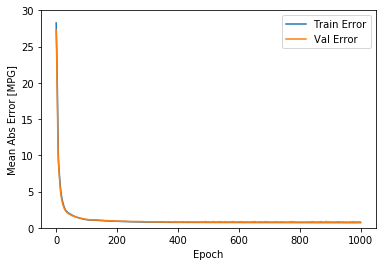

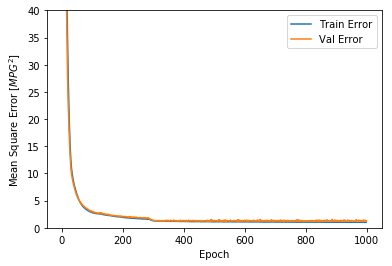

In [82]:
# For these plots, our error is super low. There might be bugs because of
# the way we normalize
# TODO: Fix normalization

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()

plot_history(history_object_A)

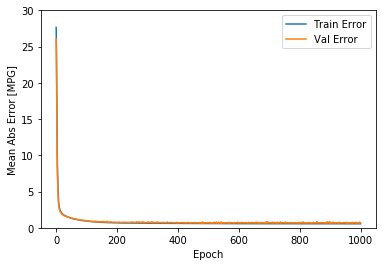

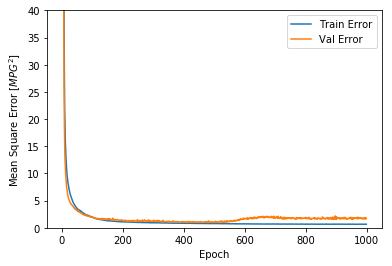

In [83]:
plot_history(history_object_B)

In [98]:
# Range of how wrong we allow a prediction to be, random number for now. unsure what is considered "good"
def accuracy(errorVec, epsilon):
    numExamples = len(errorVec)
    numCorrect = 0
    for error in errorVec:
        if abs(error) <= epsilon:
            numCorrect += 1
    print((numCorrect / float(numExamples))*100,"%")

epsilon = 5
test_predictions_B = model_B.predict(normed_test).flatten()
errorVec = test_predictions_B - test_labels
accuracy(errorVec, epsilon)



98.64559819413093 %
